In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt

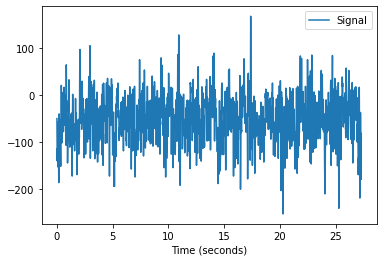

In [6]:
eeg = nk.data(dataset="eeg")
nk.signal_plot(eeg, sampling_rate=150)

In [15]:
import pickle
with open('eeg_1min_200hz.pickle', 'rb') as pickle_file:
    raw = pickle.load(pickle_file)
raw.info

<Info | 20 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: 1 items (EEG 053)
 ch_names: STI 001, STI 002, STI 003, STI 004, STI 005, STI 006, STI 014, ...
 chs: 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 100.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 70
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: []
 sfreq: 200.0 Hz
>

In [19]:
print(type(raw._data))
print(raw._data.shape)
scan_durn = raw._data.shape[1] / raw.info['sfreq']
print('Duration of EEG recording = ', scan_durn,
      's, or', scan_durn / 60, 'min.')


<class 'numpy.ndarray'>
(70, 12000)
Duration of EEG recording =  60.0 s, or 1.0 min.


/var/folders/j_/3nq1pt5x6yqcx3k5d68vn4mc0000gq/T/ipykernel_19503/3611353603.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


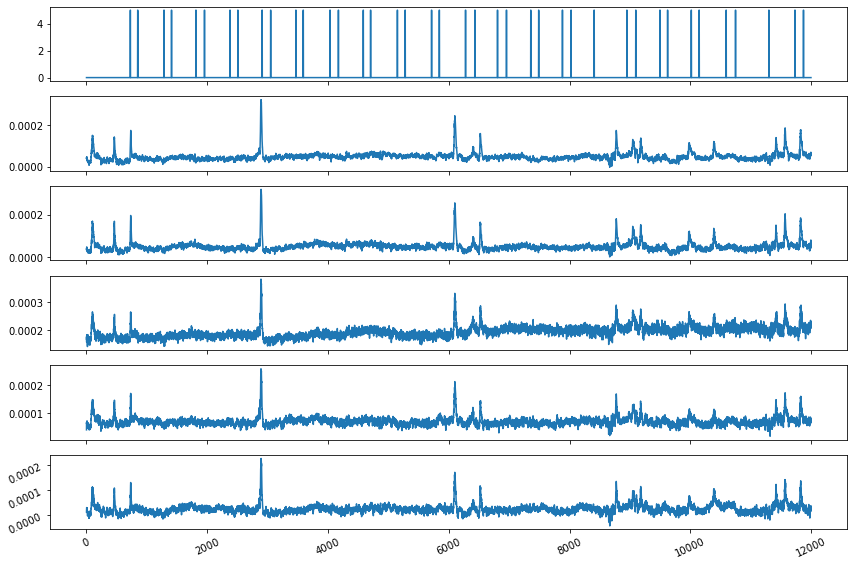

In [28]:
import seaborn as sns
stimulus = raw._data[1, :]
eeg1 = raw._data[10, :]
eeg2 = raw._data[11, :]
eeg3 = raw._data[12, :]
eeg4 = raw._data[13, :]
eeg5 = raw._data[14, :]

eog = raw._data[69, :]

# Plot PPG
# create the time series subplots
fig,ax = plt.subplots( 6, 1,
					figsize = ( 12, 8),
					sharex = True)

x = np.arange(0,raw._data.shape[1])


ax[-1].tick_params(labelrotation = 25)
sns.lineplot( x = x, y = stimulus, ax = ax[0])
sns.lineplot( x = x, y = eeg1, ax = ax[1])
sns.lineplot( x = x, y = eeg2, ax = ax[2])
sns.lineplot( x = x, y = eeg3, ax = ax[3])
sns.lineplot( x = x, y = eeg4, ax = ax[4])
sns.lineplot( x = x, y = eeg5, ax = ax[5])


fig.tight_layout(pad = 1.2)
fig.show()


### Empirical Mode Decomposition and Wavelet Transform

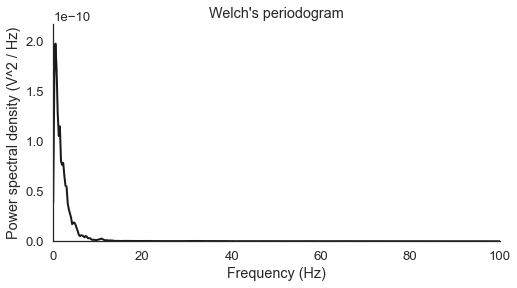

In [29]:
data = eeg1
sf = 200
from scipy import signal

# Define window length (4 seconds)
win = 4 * sf
freqs, psd = signal.welch(data, sf, nperseg=win)

# Plot the power spectrum
sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
sns.despine()


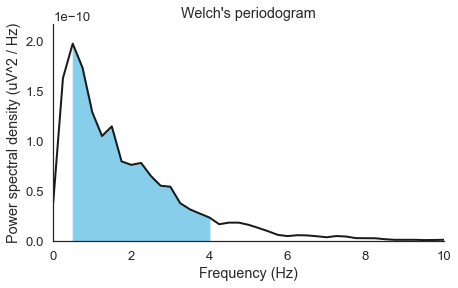

In [30]:
# Define delta lower and upper limits
low, high = 0.5, 4

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()


* delta (1–3 Hz)
* theta (4–7 Hz)
* alpha (8–12 Hz)
* beta (13–30 Hz)
* gamma (30–100 Hz)

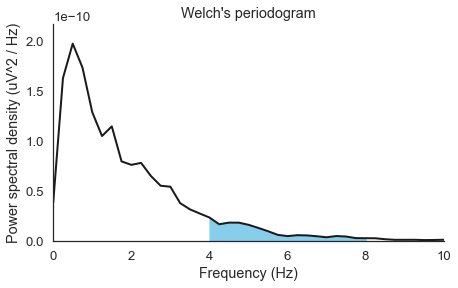

In [31]:
# Define theta lower and upper limits
low, high = 4, 8

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

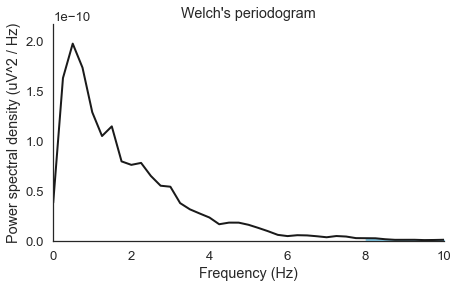

In [32]:
# Define alpha lower and upper limits
low, high = 8, 12

# Find intersecting values in frequency vector
idx_delta = np.logical_and(freqs >= low, freqs <= high)

# Plot the power spectral density and fill the delta area
plt.figure(figsize=(7, 4))
plt.plot(freqs, psd, lw=2, color='k')
plt.fill_between(freqs, psd, where=idx_delta, color='skyblue')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (uV^2 / Hz)')
plt.xlim([0, 10])
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
sns.despine()

In [ ]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    from scipy.signal import welch
    from scipy.integrate import simps
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp
